In [1]:
import pandas as pd
import numpy as np

import wrds

from dotenv import dotenv_values
config = dotenv_values(".env")

from mylib.load_from_wrds import query_options_stock, query_zero_curve
from mylib.rates_tools import create_yield_curve, merge_interest
from mylib.construct_tracer import construct_tracer
from mylib.BS_formulas import bs_delta, bs_IV

%load_ext autoreload
%autoreload 2

In [2]:
secid = 113993
name = "Game Stop"
ticker = "GME"

startdate = '2019-01-01'
enddate = '2022-12-31'

ALLOWED_ADJ_FACTOR_CHANGE = [0.99, 1.01]    #to filter options where adjustment factor changes over lifetime

# Download data from WRDS and do some preliminary cleaning

In [3]:
%%time

db = wrds.Connection(wrds_username=config['WRDS_USER'])

df_option = query_options_stock(db, secid, startdate=startdate, enddate=enddate)
zero_curve = query_zero_curve(db, startdate=startdate, enddate=enddate)


Loading library list...
Done
CPU times: user 5.33 s, sys: 964 ms, total: 6.29 s
Wall time: 16.3 s


In [4]:
def query_dividend(db, secid, startdate='2019-01-01', enddate='2022-12-31'):
    query = '''
    SELECT secid, record_date, distr_type, amount, ex_date
    FROM optionm.distrd
    WHERE secid=%s
    AND ex_date BETWEEN '%s' AND '%s'
    ''' %  (secid, startdate, enddate)
    
    df = db.raw_sql(query, date_cols=['ex_date'])     
    return df

def query_stock(db, secid, startdate='2019-01-01', enddate='2022-12-31'):
    
    enddate_stock = str(int(enddate[0:4])+1) + enddate[4:]    # load one additional year
    
    query = '''
    SELECT secid, date, close, cfret
    FROM optionm.secprd
    WHERE secid=%s
    AND date BETWEEN '%s' AND '%s'
    ORDER BY date ASC
    ''' % (secid, startdate, enddate_stock)

    df = db.raw_sql(query, date_cols=['date'])
    df['adjClose'] = df['close'] * df['cfret'] / df.loc[len(df)-1]['cfret']
    return df

df_stock = query_stock(db, secid, startdate=startdate, enddate=enddate)
df_dividend = query_dividend(db, secid, startdate=startdate, enddate=enddate)

db.close()
df_dividend.head(3)

,secid,record_date,distr_type,amount,ex_date
0,113993.0,2019-03-15,1,0.38,2019-03-14
1,113993.0,2022-07-18,3,0.00,2022-07-22


In [5]:
df_dist = pd.merge(df_stock, df_dividend.loc[df_dividend['distr_type'].isin(['2', '3']), ['secid', 'distr_type', 'ex_date']], 
                   how = 'left', left_on = ['date', 'secid'], right_on = ['ex_date', 'secid'])

df_factor = pd.concat([ df_dist.loc[df_dist[df_dist['distr_type'].notna()].index-1, :], df_dist.loc[df_dist['distr_type'].notna(), :] ]).reset_index()
df_factor['splitfactor'] = df_factor['cfret']
df_factor['splitfactor'] = df_factor.loc[:, 'splitfactor'] / df_factor.loc[len(df_factor)-1, 'splitfactor']

df_adj = pd.concat([df_dist.loc[[0], :], df_dist.loc[df_dist[df_dist['distr_type'].notna()].index-1, :] ]).reset_index()
df_adj['adj_fac'] = df_adj['cfret']
df_adj['adj_fac'] = df_adj.loc[:, 'adj_fac'] / df_adj.loc[len(df_adj)-1, 'adj_fac']

In [6]:
df_option_adj = pd.merge(df_option, df_factor[['secid', 'date', 'splitfactor']], how = 'left', on = ['secid', 'date']).sort_values(['date', 'exdate','cp_flag','K'])
df_option_adj['splitfactor'] = df_option_adj['splitfactor'].ffill().bfill()
df_option_adj['K_adj'] = df_option_adj['K'] * df_option_adj['splitfactor']
df_option_adj['V0_adj'] = df_option_adj['V0'] * df_option_adj['splitfactor']

df_option_adj = df_option_adj.merge(df_adj[['secid', 'date', 'adj_fac']], how = 'left', on = ['secid', 'date']).sort_values(['date', 'exdate','cp_flag','K'])
df_option_adj['adj_fac'] = df_option_adj['adj_fac'].ffill().bfill()
df_option_adj

,secid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,...,V0,S0,adj_fac0,adj_fac1,M0,open_total_interest,splitfactor,K_adj,V0_adj,adj_fac
0,113993.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,...,6.025,13.07,2.877128,2.877128,1.867143,92774.0,0.25,1.749999,1.506249,0.966461
1,113993.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,...,5.875,13.07,2.877128,2.877128,1.742667,92774.0,0.25,1.874999,1.468750,0.966461
2,113993.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,...,4.885,13.07,2.877128,2.877128,1.633750,92774.0,0.25,1.999999,1.221250,0.966461
3,113993.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,...,4.305,13.07,2.877128,2.877128,1.537647,92774.0,0.25,2.124999,1.076250,0.966461
4,113993.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,...,3.305,13.07,2.877128,2.877128,1.452222,92774.0,0.25,2.249999,0.826250,0.966461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208669,113993.0,2022-12-30,2023-02-17,P,1.949371,-0.947138,0.0,85.0,100.0,49,...,51.675,18.46,11.907900,11.907900,0.263714,641957.0,1.00,70.000000,51.675000,1.000000
1208670,113993.0,2022-12-30,2023-02-17,P,2.057024,-0.936941,0.0,123.0,100.0,49,...,54.225,18.46,11.907900,11.907900,0.254621,641957.0,1.00,72.500000,54.225000,1.000000
1208671,113993.0,2022-12-30,2023-02-17,P,1.993416,-0.953791,0.0,100.0,100.0,49,...,56.650,18.46,11.907900,11.907900,0.246133,641957.0,1.00,75.000000,56.650000,1.000000
1208672,113993.0,2022-12-30,2023-02-17,P,2.070321,-0.948266,0.0,88.0,100.0,49,...,59.175,18.46,11.907900,11.907900,0.238194,641957.0,1.00,77.500000,59.175000,1.000000


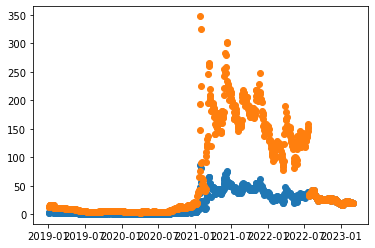

In [7]:
import matplotlib.pyplot as plt
plt.scatter(df_stock.date, df_stock.adjClose)
plt.scatter(df_stock.date, df_stock.close)

#### seperate notebook: write a function check the type of dividends and adjust the price to the level after the stock split:

!!!
option price

stock price

strike price

adjustment factor

In [29]:
def filter_adj_factor_change(df, ALLOWED_ADJ_FACTOR_CHANGE=[0.99, 1.01]):
    adj_change = df['adj_fac1'] / df['adj_fac0']
    bl = (ALLOWED_ADJ_FACTOR_CHANGE[0] > adj_change) | (adj_change > ALLOWED_ADJ_FACTOR_CHANGE[1])    
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed due to a large change in adjustment factor.')
    
    return df[~bl]

In [30]:
df_option = filter_adj_factor_change(df_option, ALLOWED_ADJ_FACTOR_CHANGE)

There are 128454 (10.63%) options that are removed due to a large change in adjustment factor.


Add interest rates and underlying info to options dataframe:

In [31]:
%%time

df_rate = create_yield_curve(zero_curve, max_days=1500) 
df = merge_interest(df_option, df_rate)

CPU times: user 1.89 s, sys: 1.52 s, total: 3.41 s
Wall time: 3.42 s


In [32]:
def add_next_observation(df):
    # adding future values to dataframe
    grouped = df.groupby(['secid', 'exdate', 'K', 'cp_flag'])
    df['S1'] = grouped['S0'].shift(-1)
    df['r1'] = grouped['r'].shift(-1)
    df['IV1'] = grouped['IV0'].shift(-1)
    df['tau1'] = grouped['tau'].shift(-1)
    df['V1'] = grouped['V0'].shift(-1)
    return df

In [33]:
df = add_next_observation(df)

In [34]:
def filter_data_pre_tracer(df):
    orig_size = len(df)
    #-----------------------------------------
    # Filter by missing price data
    #-----------------------------------------
    bl = df['S0'].isnull() | df['V0'].isnull() | df['S1'].isnull() | df['V1'].isnull()
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed due missing price data.')   
    #these are options with zero days to maturity or at the enddate
    df = df.loc[~bl]

    #-----------------------------------------
    # Filter by open_interest
    #-----------------------------------------
    bl = df['open_interest'].eq(0)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed because of zero interest.')   
    #these are options with zero days to maturity or at the enddate
    df = df.loc[~bl]

    #----------------------
    #  filter by volume and open interest
    #----------------------    
    CUTOFF_DAILY_INTEREST = 0.01
    bl = df['volume'].eq(0) & df['open_interest'].div(df['open_total_interest']).lt(CUTOFF_DAILY_INTEREST)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed due no volume and small open interest.')
    df = df[~bl]

    n_removed = orig_size - len(df)
    print(f'Removed in total: {n_removed} ({n_removed/orig_size*100:.2f}%) of all options. New data size: {len(df)}.') 
    return df

In [35]:
df = filter_data_pre_tracer(df)

There are 29308 (2.71%) options that are removed due missing price data.
There are 226941 (21.59%) options that are removed because of zero interest.
There are 336682 (40.86%) options that are removed due no volume and small open interest.
Removed in total: 592931 (54.89%) of all options. New data size: 487289.


# Construct tracer options and calculate implied dividends

In [36]:
%%time

df_tracer = pd.DataFrame()
for target_tau_days in [30, 60, 90, 120, 150, 180]:
    for cp_flag in ['C', 'P']:
        df_tmp = construct_tracer(df, df_rate, cp_flag, target_tau_days, ALLOWED_ADJ_FACTOR_CHANGE)
        df_tracer = pd.concat([df_tracer, df_tmp])

CPU times: user 23.6 s, sys: 365 ms, total: 24 s
Wall time: 23.9 s


In [37]:
def calc_implied_div(df_tracer):
    df_c = df_tracer[(df_tracer['cp_flag'] == 'C')]
    df_p = df_tracer[(df_tracer['cp_flag'] == 'P')]
    df = df_c.merge(df_p, on=['date', 'K', 'tau_days'], suffixes=[None, '_P'])
    df['impl_div'] = np.maximum(-1/df['tau'] * np.log((df['V0'] - df['V0_P'])/df['K'] + np.exp(-df['r'] * df['tau'])), 0)    
    return df[['date', 'tau_days', 'impl_div']]

In [38]:
## calculate implied dividend
df_impl_div = calc_implied_div(df_tracer)
df_impl_div.tail()

,date,tau_days,impl_div
4920,2022-08-09,180,0.302648
4921,2022-08-15,180,0.390959
4922,2022-08-16,180,0.294305
4923,2022-08-18,180,0.210296
4924,2022-08-19,180,0.235085


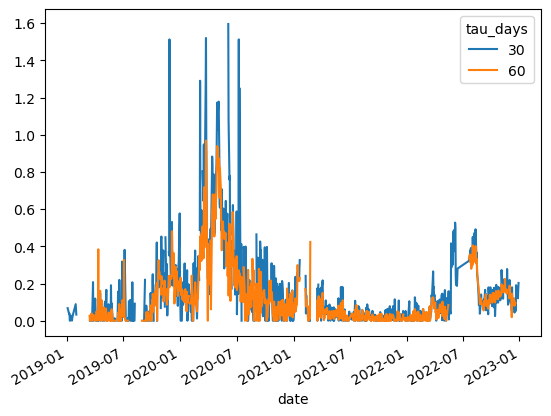

In [39]:
df_impl_div.pivot(index='date', columns='tau_days')['impl_div'][[30, 60]].plot();

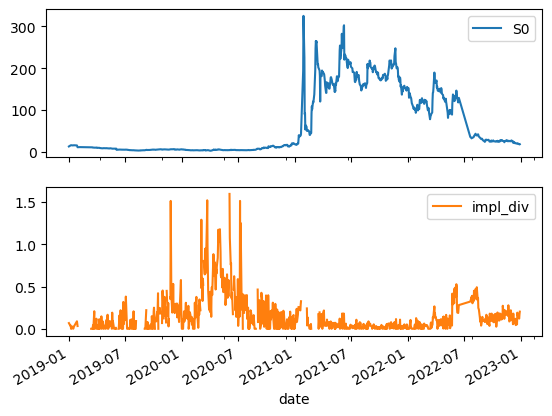

In [40]:
df[['date', 'S0']].drop_duplicates().merge(df_impl_div[df_impl_div['tau_days']==30][['date', 'impl_div']], 
                                           on='date').set_index('date', drop=True).plot(subplots=True);

#!!! check again plot after price adjustment is implemented

In [41]:
df_tracer = pd.merge(df_tracer, df_impl_div, how='left', on=['date', 'tau_days'])

# Filter data

In [42]:
def filter_data_post_tracer(df):
    orig_size = len(df)

    #---------------------------------
    # Keep out-the-money options only
    #---------------------------------
    bl = ((df['cp_flag'] == 'C') & (df['M0'] > 1.001)) | ((df['cp_flag'] == 'P') & (df['M0'] < 0.999))
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed due being in-the-money.')
    df = df.loc[~bl]


    #--------------------
    # Filter by Maturity
    #--------------------
    bl = df['tau_days'].le(5)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed due being too close to expiry.')
    df = df[~bl]

    
    #----------------------------------------------------
    #  filter all the option with negative time value
    #----------------------------------------------------
    bl_c = (df['cp_flag'] == 'C') & (df['S0'] - np.exp(-df['r'] * df['tau']) * df['K'] >= df['V0'])
    bl_p = (df['cp_flag'] == 'P') & (np.exp(-df['r'] * df['tau']) * df['K'] - df['S0'] >= df['V0'])
    bl = bl_c | bl_p
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed due negative time value.')   
    df = df.loc[~bl]

    
    n_removed = orig_size - len(df)
    print(f'Removed in total: {n_removed} ({n_removed/orig_size*100:.2f}%) of all options. New data size: {len(df)}.') 
    return df

In [43]:
df = filter_data_post_tracer(df)

There are 147145 (30.20%) options that are removed due being in-the-money.
There are 43775 (12.87%) options that are removed due being too close to expiry.
There are 0 (0.00%) options that are removed due negative time value.
Removed in total: 190920 (39.18%) of all options. New data size: 296369.


# Fill in implied vols and compute deltas

In [87]:
%%time

df.loc[df['IV0'].isna(), 'IV0_c'] = df.loc[df['IV0'].isna(), :].apply(lambda x:bs_IV(**x), axis=1)

CPU times: user 49.3 s, sys: 5.22 s, total: 54.5 s
Wall time: 49.7 s


In [25]:
pd.set_option('display.max_columns', None)
df.head(2)

,secid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,adj_fac1,M0,open_total_interest,short_rate,r,S1,r1,IV1,tau1,V1,IV0_c
188,113993.0,2022-01-03,2022-01-14,C,0.779201,0.486062,74.0,250.0,100.0,11,0.030556,155.0,7.275,152.84,2.976974,2.976974,0.986065,229688.0,0.005184,0.005187,148.91,0.005109,0.862720,0.027778,5.95,NaN
189,113993.0,2022-01-03,2022-01-14,C,0.798112,0.441851,29.0,18.0,100.0,11,0.030556,157.5,6.450,152.84,2.976974,2.976974,0.970413,229688.0,0.005184,0.005187,148.91,0.005109,0.852462,0.027778,5.00,NaN


1) Fill in missing IVs
2) add implied dividends to the df data frame
3) compute various deltas
4) do some scatter plots for the various deltas (on the origianl dataset, and maybe also on the tracer dataset)

2 might require some interpolation

In [ ]:

df['normDelta'] = df.apply(lambda row: bs_delta(row['IV0'], row['S0'], row['K'], row['tau'], row['r'], 0, row['cp_flag']), axis=1)
df.loc[df['delta'].isna(), 'delta'] = df.loc[df['delta'].isna(), 'normDelta'] 


# Calculate adjusted delta

In [27]:
df_syn['adjDelta'] = df_syn.apply(lambda row: bs_delta(row['IV0'], row['K'], row['K'], row['tau'], row['r'], row['impl_div'], row['cp_flag']), axis=1)
df_syn['normDelta'] = df_syn.apply(lambda row: bs_delta(row['IV0'], row['K'], row['K'], row['tau'], row['r'], 0, row['cp_flag']), axis=1)

grouped = df_syn[['date', 'S0']].drop_duplicates()
grouped['S1'] = grouped['S0'].shift(-1)
df_syn = pd.merge(df_syn, grouped[['date', 'S1']], on = 'date', how = 'left')

df_syn = df_syn.rename(columns = {'IV_interp': 'IV'})
# missing values: should be revised later
# drop missing values:
df_syn = df_syn.loc[~np.isnan(df_syn['IV']), :]
df_syn = df_syn.loc[~np.isnan(df_syn['S1']), :]

df_syn.head(2)

,date,S0,IV,K,cp_flag,tau_days,tau,short_rate,r,V0,V1,impl_div0,impl_cdiv0,adjDelta,normDelta,S1
0,2019-01-02,13.07,0.607807,13.07,C,30,0.083333,0.024478,0.025773,0.926809,0.800769,0.024874,0.024876,0.535123,0.539816,12.97
1,2019-01-02,13.07,0.625878,13.07,P,30,0.083333,0.024478,0.025773,0.925830,0.910249,0.024874,0.024876,-0.463845,-0.459289,12.97


# Regression

In [87]:
def func_reg(train, test, weight, delta_var = 'adjDelta'): 
    
    df_train = train.copy()
    df_test = test.copy()
    df_weight = weight.copy()

    delta_hat = pd.Series(index=df_test.index, dtype = 'float64')
    dict_output = {}
    dict_plot = {}


    for optype, group in df_train.groupby(by='cp_flag'):
        test_index = df_test.loc[df_test['cp_flag'] == optype].index
        dict_coef = {}        

        ## add weights
        group = pd.merge(group, df_weight, how = 'left', on = 'date')

        ## y_train is the change of option price in the training set
        y_train = group['V1'] - group['V0'] * group['short_rate']
        ## x_train is Delta times the change of stock price in the training set
        w_train = group.loc[:, 'weight'].copy()
        x_train = group.loc[:, delta_var].copy()
        x_train = x_train.multiply(group['S1'] - group['S0'] * group['short_rate'], axis=0).values.reshape(-1,1)
        lin = LinearRegression(fit_intercept=False).fit(x_train, y_train, sample_weight = group['weight'])
        coef = lin.coef_
        
        dict_plot[optype + '_x_train'] = x_train
        dict_plot[optype + '_y_train'] = y_train
        dict_plot[optype + '_w_train'] = w_train
        dict_plot[optype + '_coef'] = coef

        ## y_hat_test is predicted delta in the test set 
        if len(df_test[(df_test['cp_flag'] == optype)]) < 1:
            print('test set of ' + optype + ' has insufficient observations')
            pass
        else:
            delta_hat.loc[test_index] = lin.predict(df_test.loc[test_index, delta_var].values.reshape(-1,1))

            y_test = df_test.loc[test_index, 'V1'] - df_test.loc[test_index, 'V0'] * df_test.loc[test_index, 'short_rate']
            x_test = df_test.loc[test_index, delta_var].copy()
            x_test = x_test.multiply(df_test.loc[test_index, 'S1'] - df_test.loc[test_index, 'S0'] * df_test.loc[test_index, 'short_rate'], axis=0).values.reshape(-1,1)  

            dict_plot[optype + '_x_test'] = x_test
            dict_plot[optype + '_y_test'] = y_test
            dict_plot[optype + '_predict'] = lin.predict(x_test)   

        dict_coef['coef'] = coef
        dict_coef['N_train'] = len(group)
        dict_coef['days_train'] = len(np.unique(group.date))
        dict_coef['N_test'] = len(df_test.loc[test_index])
        dict_coef['days_test'] = len(np.unique(df_test.loc[test_index].date))
        dict_output[optype] = dict_coef
    
    return dict_output, dict_plot

In [97]:
%%time
from sklearn.linear_model import LinearRegression

flag = "tracer" 
if flag == "tracer":
    temp = df_syn.copy()
    delta_type = "adjDelta"
else:
    temp = df.copy()
    delta_type = "delta"


############# Calculating result using pre-bubble data ####################
df_MSHE = pd.DataFrame()
df_PNL = pd.DataFrame()
dict_output = {}
dict_plot = {}

train_length = 240
step = 1
wt_exp = [0.99**i for i in range(train_length-1, -1, -1)]

all_date = np.unique(temp.loc[:, 'date'])
train_date = all_date[0:train_length]
test_date = all_date[train_length:]
df_test = temp[temp['date'].isin(test_date)]

for s in range(int(np.ceil(len(test_date)/step))):
    test_date_in = test_date[0:step]
    first_test_date = str(test_date_in[0])[:10]
    df_train_rolling = temp[temp['date'].isin(train_date)]
    df_test_rolling = temp[temp['date'].isin(test_date_in)]
    df_weight_rolling = pd.DataFrame({'date':train_date, 'weight':wt_exp})

    dict_output_one, dict_plot_one = func_reg(df_train_rolling, df_test_rolling, df_weight_rolling, delta_type)
    dict_output[first_test_date] = dict_output_one
    dict_plot[str(test_date_in[0])[:10]] = dict_plot_one

    train_date = np.concatenate([train_date[step:], test_date[0:step]])
    test_date = test_date[step:]
    
df_coef_ts = pd.DataFrame()

for key in dict_output:
    df_coef_ts.loc[key, 'date'] = pd.to_datetime(key)
    df_coef_ts.loc[key, 'coef_C'] = dict_output[key]['C']['coef']
    df_coef_ts.loc[key, 'N_train_C'] = dict_output[key]['C']['N_train']
    df_coef_ts.loc[key, 'days_train_C'] = dict_output[key]['C']['days_train']
    df_coef_ts.loc[key, 'N_test_C'] = dict_output[key]['C']['N_test']

    df_coef_ts.loc[key, 'coef_P'] = dict_output[key]['P']['coef']
    df_coef_ts.loc[key, 'N_train_P'] = -dict_output[key]['P']['N_train']
    df_coef_ts.loc[key, 'days_train_P'] = dict_output[key]['P']['days_train']
    df_coef_ts.loc[key, 'N_test_P'] = dict_output[key]['P']['N_test']   
    

test set of P has insufficient observations
test set of P has insufficient observations
test set of P has insufficient observations
test set of P has insufficient observations
test set of P has insufficient observations
CPU times: user 4.25 s, sys: 138 ms, total: 4.39 s
Wall time: 4.43 s


# plot scatter:

In [98]:
def plot_scatter(dict_plot_input, secid, date_in):
    
    dict_plot_one = dict_plot_input[date_in]
    plt.rc('font', size=25)          # controls default text sizes

    fig, axs = plt.subplots(1, 2, figsize=(18,9), sharex=True, sharey=True)
    # fig.suptitle(ticker + ' ' + str(i) + ' ' + ids[i].strip() + ' ' + date_in)
    plt.setp(axs[:], xlabel= "Adjusted delta X Change of stock price")
    plt.setp(axs[0], ylabel="Change of option price")
    
    w_C = dict_plot_one['C_w_train'] * 30
    axs[0].scatter(dict_plot_one['C_x_train'], dict_plot_one['C_y_train'], s = w_C)
    axs[0].plot(dict_plot_one['C_x_train'], dict_plot_one['C_coef'] * dict_plot_one['C_x_train'], color='tab:orange')
    axs[0].scatter(dict_plot_one['C_x_test'], dict_plot_one['C_y_test'], color='tab:red')
    axs[0].annotate('Call Coefficient: ' + str(round(dict_plot_one['C_coef'][0], 4)), 
                    xy=(0, 1), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points')
    axs[0].set_title("Call")
    
    w_P = dict_plot_one['P_w_train'] * 30
    axs[1].scatter(dict_plot_one['P_x_train'], dict_plot_one['P_y_train'], s = w_P)
    axs[1].plot(dict_plot_one['P_x_train'], dict_plot_one['P_coef'] * dict_plot_one['P_x_train'], color='tab:orange')
    axs[1].scatter(dict_plot_one['P_x_test'], dict_plot_one['P_y_test'], color='tab:red')
    axs[1].annotate('Put Coefficient: ' + str(round(dict_plot_one['P_coef'][0], 4)), 
                    xy=(0, 1), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points')
    axs[1].set_title("Put")   
    fig.tight_layout()   
    plt.close()
    return fig

    # scatter_output_path = output_path + 'scatter/' + str(secid) + '/'
    # if not os.path.exists(scatter_output_path):
    #     os.makedirs(scatter_output_path)
    # plt.savefig(scatter_output_path + str(secid) + '_' + ticker + '_' + date_in + '.jpg')  
    # plt.close()

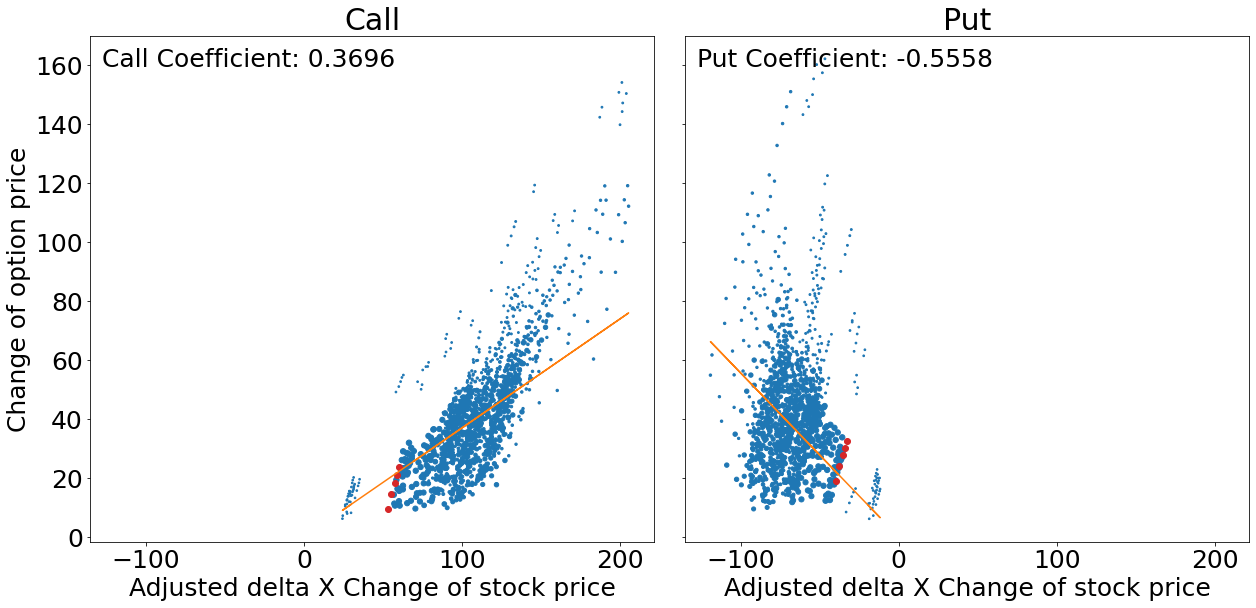

In [99]:
import matplotlib.pyplot as plt
plot_scatter(dict_plot, secid, '2022-01-26')

# plot coefficient:

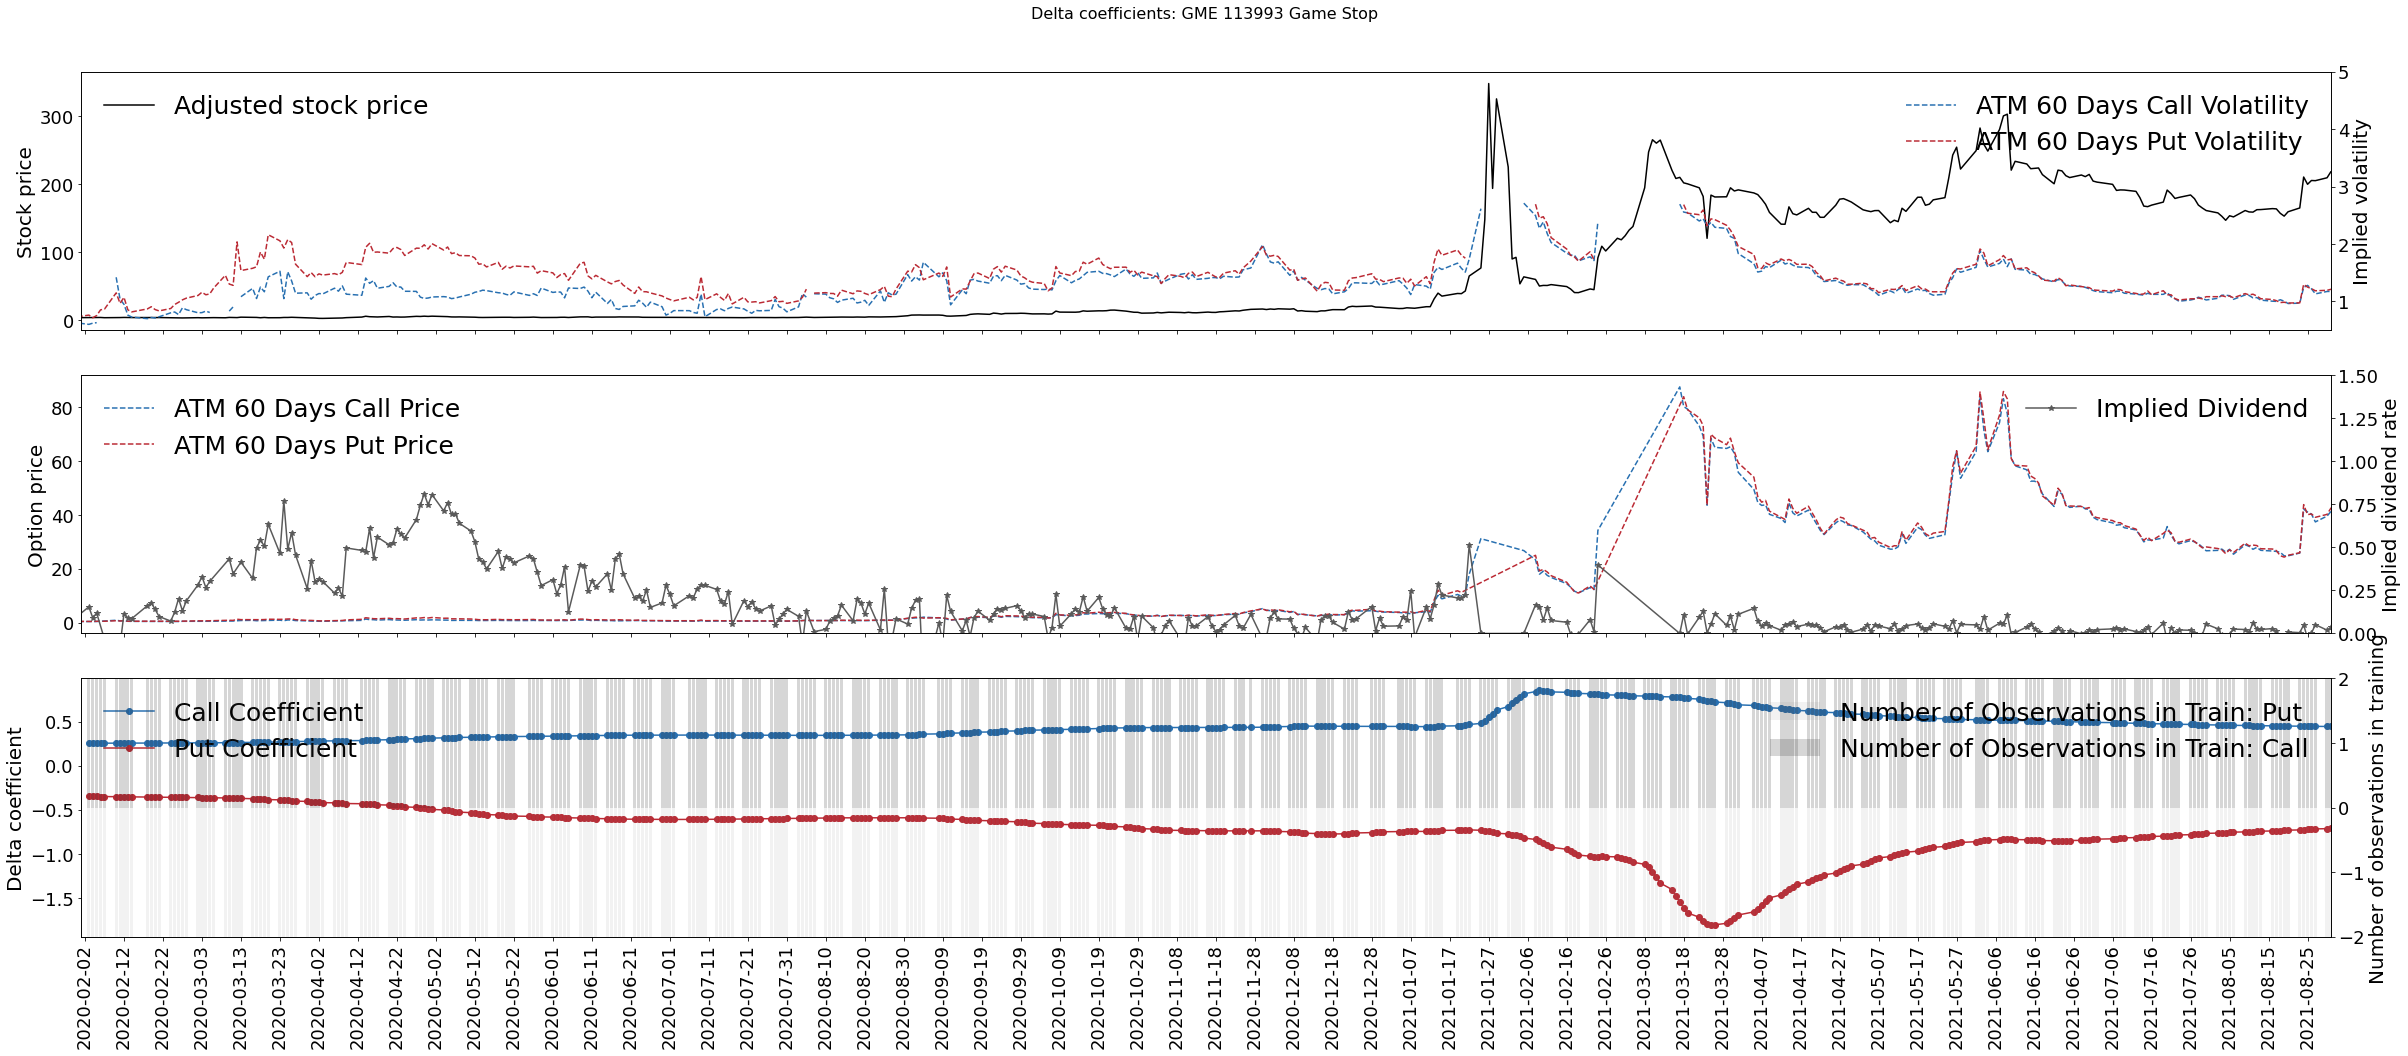

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

df_syn_impl_div_C60 = df_syn.loc[(df_syn['tau_days'] == 60) & (df_syn['cp_flag'] == 'C'),['date', 'V0', 'impl_cdiv0']]   
df_syn_impl_div_P60 = df_syn.loc[(df_syn['tau_days'] == 60) & (df_syn['cp_flag'] == 'P'),['date', 'V0', 'impl_cdiv0']]   

df_coef_ts['dif'] = df_coef_ts['coef_C'] - df_coef_ts['coef_P']
df_coef_ts = df_coef_ts.sort_values(['date'])
df_coef_ts['coef_C_SMA10'] = df_coef_ts['coef_C'].rolling(10).mean()
df_coef_ts['coef_P_SMA10'] = df_coef_ts['coef_P'].rolling(10).mean()
df_coef_ts['EWMA10'] = df_coef_ts['dif'].ewm(span=10).mean()
df_coef_ts['SMA10'] = df_coef_ts['dif'].rolling(10).mean()

df_coef_ts_plot = df_coef_ts.merge(df_syn[['date', 'S0']].drop_duplicates(), how = 'left', on = 'date')
df_coef_ts_plot = df_coef_ts_plot.merge(df_syn.loc[(df_syn['tau_days'] == 60) & (df_syn['cp_flag'] == 'C') , ['date', 'IV']].drop_duplicates(), how = 'left', on = 'date')
df_coef_ts_plot.rename(columns={'IV': 'IV_C60'}, inplace = True)
df_coef_ts_plot = df_coef_ts_plot.merge(df_syn.loc[(df_syn['tau_days'] == 60) & (df_syn['cp_flag'] == 'P') , ['date', 'IV']].drop_duplicates(), how = 'left', on = 'date')
df_coef_ts_plot.rename(columns={'IV': 'IV_P60'}, inplace = True)


fig, axs = plt.subplots(3, 1, figsize=(34,15), sharex=True, sharey=False)                
axs[0].plot(df_coef_ts_plot.date, df_coef_ts_plot.S0, 'k', label='Adjusted stock price')
axs[0].set_ylabel("Stock price", fontsize=20)
axs[0].tick_params(axis='y', labelsize=18)    
axs[0].legend(loc=2, frameon=False)
ax0 = axs[0].twinx()
ax0.plot(df_coef_ts_plot.date, df_coef_ts_plot.IV_C60, color = sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label='ATM 60 Days Call Volatility')
ax0.plot(df_coef_ts_plot.date, df_coef_ts_plot.IV_P60, color = sns.color_palette("RdBu", n_colors=7)[0], linestyle='dashed', label='ATM 60 Days Put Volatility')
ax0.set_ylabel("Implied volatility", fontsize=20) 
ax0.tick_params(axis='y', labelsize=18)    
ax0.set_ylim([0.5, 5]) 
ax0.legend(loc=1, frameon=False)  

axs[1].plot(df_syn_impl_div_C60.date, df_syn_impl_div_C60.V0, color = sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label='ATM 60 Days Call Price')
axs[1].plot(df_syn_impl_div_P60.date, df_syn_impl_div_P60.V0, color = sns.color_palette("RdBu", n_colors=7)[0], linestyle='dashed', label='ATM 60 Days Put Price')
axs[1].set_ylabel("Option price", fontsize=20)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].legend(loc=2, frameon=False)
ax1 = axs[1].twinx()
ax1.plot(df_syn_impl_div_C60.date, df_syn_impl_div_C60.impl_cdiv0, color = sns.color_palette("RdGy", n_colors=7)[6], marker = '*', label='Implied Dividend')
ax1.set_ylabel("Implied dividend rate", fontsize=20)
ax1.tick_params(axis='y', labelsize=18)
ax1.set_ylim([0, 1.5]) 
ax1.legend(loc=1, frameon=False)  

#     axs[2].plot(df_coef_ts.date, df_coef_ts.EWMA10, 'bo', label='EWMA 10')
#     axs[2].plot(df_coef_ts.date, df_coef_ts.SMA10, 'ro', label='SMA 10') 
axs[2].plot(df_coef_ts_plot.date, df_coef_ts_plot.coef_C_SMA10, color = sns.color_palette("RdBu", n_colors=7)[6], marker = 'o', label='Call Coefficient')
axs[2].plot(df_coef_ts_plot.date, df_coef_ts_plot.coef_P_SMA10, color = sns.color_palette("RdBu", n_colors=7)[0], marker = 'o', label='Put Coefficient') 
axs[2].set_ylabel("Delta coefficient", fontsize=20)
axs[2].tick_params(axis='y', labelsize=18)    
# axs[2].set_ylim([0, 2])            
axs[2].legend(loc=2, frameon=False)
ax2 = axs[2].twinx()
ax2.bar(df_coef_ts_plot.date, df_coef_ts_plot.N_train_P, color=(0.5, 0.5, 0.5, 0.1), label = "Number of Observations in Train: Put")
ax2.bar(df_coef_ts_plot.date, df_coef_ts_plot.N_train_C, color=(0.2, 0.2, 0.2, 0.2), label = "Number of Observations in Train: Call")
ax2.set_ylabel("Number of observations in training", fontsize=20)  
ax2.tick_params(axis='y', labelsize=18)
maxlevel = round(max([max(abs(df_coef_ts_plot.N_train_C)), max(abs(df_coef_ts_plot.N_train_P))])/1000)*1000 + 1000
ax2.set_ylim([-2, 2]) 
ax2.legend(loc=1, frameon=False) 
axs[2].xaxis.set_major_locator(mdates.DayLocator(interval=10))
axs[2].set_xlim([pd.to_datetime('2020-02-01'), pd.to_datetime('2021-08-31')])
plt.setp(axs[2].get_xticklabels(), rotation=90, fontsize=18)

fig.suptitle('Delta coefficients: ' + ticker + ' ' + str(secid) + ' ' + name.strip(), fontsize=16, x = 0.5, y = 0.99)
fig.tight_layout()
# plt.savefig(output_path + 'coefplot/' + str(secid) + '_' + ticker + '.jpg')
# plt.close(fig)